In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

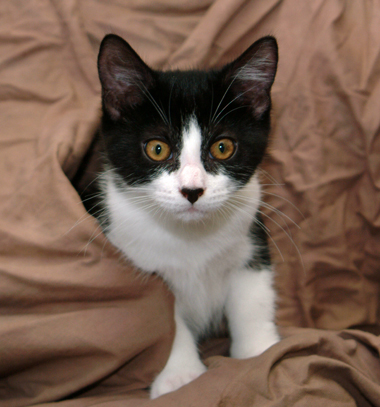

In [3]:
with Image.open('../DATA/CATS_DOGS/train/CAT/1002.jpg') as img:
    display(img)

In [4]:
path = "../DATA/CATS_DOGS/"

img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+ '//' +img)
        
print('Images: ',len(img_names))

Images:  24996


In [5]:
img_sizes = []

rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
            
    except:
        rejected.append(item) 

In [6]:
print(len(img_sizes))

24994


In [7]:
df = pd.DataFrame(img_sizes)

In [8]:
df.head()

,0,1
0,365,500
1,484,500
2,448,500
3,500,483
4,500,375


In [9]:
df[0].describe()

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 0, dtype: float64

In [10]:
df[1].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

In [11]:
dog = Image.open('../DATA/CATS_DOGS/train/DOG/14.jpg')

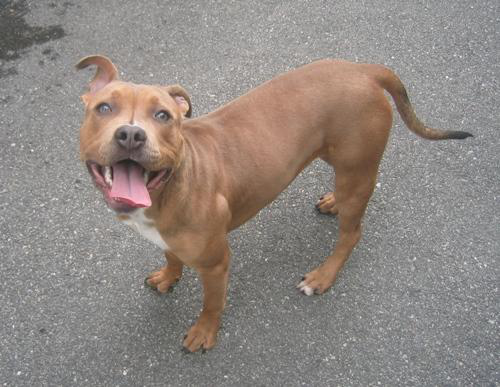

In [12]:
display(dog)

In [13]:
dog.size

(500, 387)

In [14]:
# Transform the image into tensor

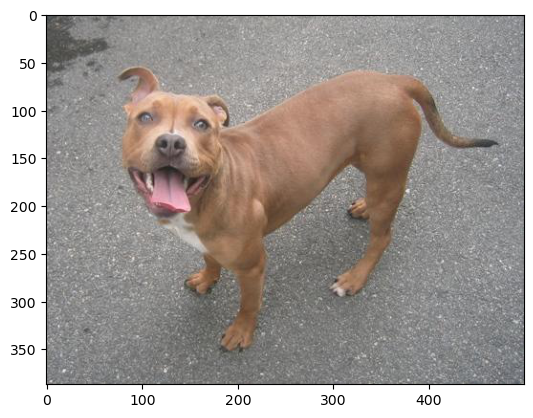

In [15]:
transform = transforms.Compose([
    transforms.ToTensor()
])

im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [16]:
im.shape

torch.Size([3, 387, 500])

In [17]:
# Resize the Image & Center Crop

# Center crop crops the image from center

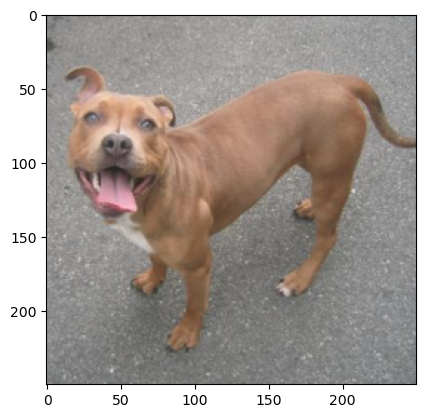

In [18]:
transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(250),
    transforms.ToTensor()
])

im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

**Transforming the Image Randomly**

- Horizontal Flip ( p = We have to set a probability of transforming an image )
- Rotation ( degrees = We have to set a degree )



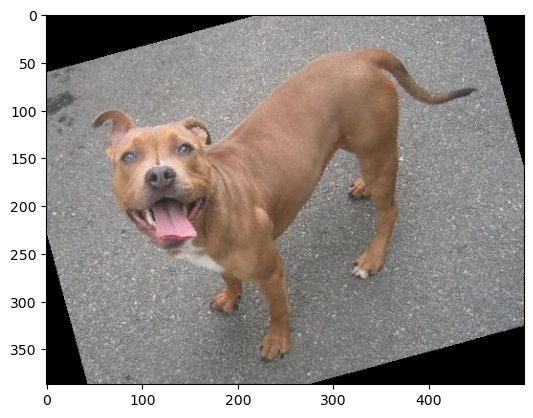

In [19]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor()
])

im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

**LETS PUT ALL TOGETHER**

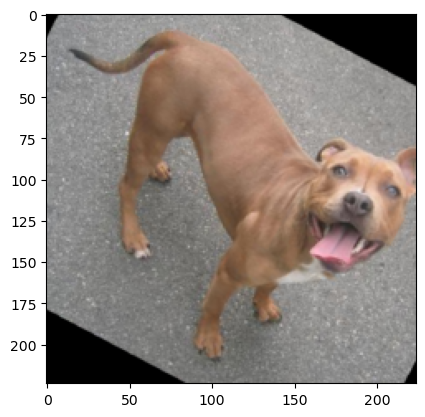

In [20]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


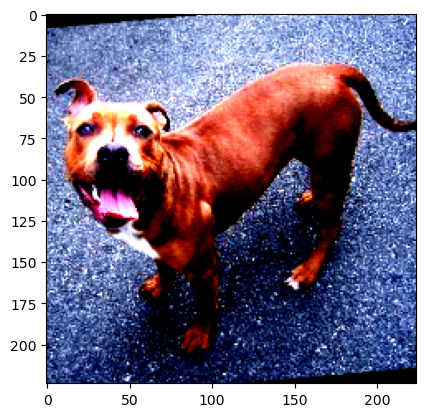

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean = [0.485, 0.465, 0.406] , std = [ 0.229, 0.224, 0.225 ] ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.Resize(224),
    transforms.CenterCrop(224)
    
])

im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

**Building a CNN for Custom Image Dataset**

In [22]:
train_transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize( mean = [0.485, 0.465, 0.406] , std = [ 0.229, 0.224, 0.225 ] ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Resize(224),
    transforms.CenterCrop(224)
    
])

In [23]:
test_transform = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize( mean = [0.485, 0.465, 0.406] , std = [ 0.229, 0.224, 0.225 ] ),
    transforms.Resize(224),
    transforms.CenterCrop(224)
])

Loading the Data

In [24]:
torch.manual_seed(42)

root = '../DATA/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root,'train'), transform = train_transform)

test_data = datasets.ImageFolder(os.path.join(root,'test'), transform = test_transform)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

class_names = train_data.classes

In [25]:
class_names

['CAT', 'DOG']

In [26]:
len(train_data)

18743

In [27]:
len(test_data)

6251

In [28]:
# Grabbing 1st batch of the images

In [29]:
for images, labels in train_loader:
    break

In [30]:
images.shape

torch.Size([10, 3, 224, 224])

In [31]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self, X):
        
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        
        X = X.view(-1,54*54*16)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [32]:
torch.manual_seed(101)

CNNmodel = ConvolutionalNetwork()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

In [33]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [34]:
for param in CNNmodel.parameters():
    print(param.numel())

162
6
864
16
5598720
120
10080
84
168
2


In [35]:
import time

start_time = time.time()

epochs = 5

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)



total_time = time.time() - start_time

print(f"The total time taken is : {total_time/60}")

epoch:  0  batch:  200 [  2000/8000]  loss: 0.59787846  accuracy:  53.700%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.46737379  accuracy:  56.275%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.64412224  accuracy:  58.783%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.53195024  accuracy:  60.475%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.39899236  accuracy:  68.500%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.55408210  accuracy:  69.450%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.56699872  accuracy:  69.533%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.48381978  accuracy:  70.362%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.60092932  accuracy:  74.400%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.36188132  accuracy:  74.800%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.58772129  accuracy:  74.867%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.46786326  accuracy:  75.138%
epoch:  3  batch:  200 [  2000/8000]  loss: 0.54420578  accuracy:  76.450%
epoch:  3  batch:  400 [ 

In [36]:
AlexNetModel = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/karthik/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|████████████████████████████████████████| 233M/233M [00:18<00:00, 13.3MB/s]


In [37]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [38]:
for param in AlexNetModel.parameters():
    param.requires_grad = False

In [39]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [40]:
torch.manual_seed(42)

AlexNetModel.classifier = nn.Sequential(nn.Linear(9216,1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(1024,2),
                                        nn.LogSoftmax(dim=1))

In [41]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [42]:
for param in AlexNetModel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetModel.classifier.parameters(), lr=0.001)

In [44]:
import time

start_time = time.time()

epochs = 2

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetModel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)



total_time = time.time() - start_time

print(f"The total time taken is : {total_time/60}")

epoch:  0  batch:  200 [  2000/8000]  loss: 0.78244603  accuracy:  88.850%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.35480398  accuracy:  90.400%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.08652993  accuracy:  91.233%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.03653508  accuracy:  91.938%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.79048443  accuracy:  95.400%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.02011422  accuracy:  94.825%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.31345496  accuracy:  94.783%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.11488472  accuracy:  94.675%
The total time taken is : 4.296947185198466
